In [ ]:
import torch
from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader
from PIL import Image, ImageDraw
import json
import numpy as np
from pathlib import Path
from torchvision.models.detection import fcos_resnet50_fpn
from torch.utils.tensorboard import SummaryWriter
from torchvision.models.detection.fcos import FCOSHead



In [2]:
class SignMountDataset(Dataset):
    def __init__(self, img_dir, anno_file, transforms=None):
        self.img_dir = Path(img_dir)
        self.transforms = transforms

        with open(anno_file) as f:
            self.annotations = json.load(f)

        self.imgs = {img['id']: img for img in self.annotations['images']}
        self.anno_map = {}
        for anno in self.annotations['annotations']:
            self.anno_map.setdefault(anno['image_id'], []).append(anno)

        self.img_ids = list(self.anno_map.keys())

     
        self.cat_id_to_label = {1: 0, 2: 1}
        self.label_to_name = {0: "Pole-mounted", 1: "Wall-mounted"}

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        img_info = self.imgs[img_id]
        img_path = self.img_dir / img_info["file_name"]

        img = Image.open(img_path).convert("RGB")
        annos = self.anno_map[img_id]

        boxes, labels = [], []
        for anno in annos:
            x, y, w, h = anno["bbox"]
            cat_id = anno["category_id"]
            if cat_id not in self.cat_id_to_label:
                continue
            boxes.append([x, y, x + w, y + h])
            labels.append(self.cat_id_to_label[cat_id])

        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)

        if self.transforms:
            img = self.transforms(img)

        target = {"boxes": boxes, "labels": labels}
        return img, target


In [3]:
def get_transform():
    """Returns transforms for training/validation"""
    return T.Compose([
        T.ToTensor(),
    ])

def collate_fn(batch):
    return tuple(zip(*batch))



In [4]:
def visualize_dataset_samples(dataset, num_samples=8):
    """Visualize processed images from dataset with bounding boxes"""
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    
    # Create figure with subplots
    cols = 4
    rows = (num_samples + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(16, 4*rows))
    axes = axes.flatten()
    
    for idx in range(min(num_samples, len(dataset))):
        img, target = dataset[idx]
        
        img_denorm = torch.clamp(img, 0, 1)
        img_np = img_denorm.permute(1, 2, 0).cpu().numpy()
        
        
        ax = axes[idx]
        ax.imshow(img_np)
        ax.set_title(f'Sample {idx+1}: Shape {img.shape}', fontsize=10)
        
        # Draw bounding boxes
        if len(target['boxes']) > 0:
            for box, label in zip(target['boxes'], target['labels']):
                x1, y1, x2, y2 = box.tolist()
                width = x2 - x1
                height = y2 - y1
                
                # Draw rectangle
                rect = patches.Rectangle(
                    (x1, y1), width, height,
                    linewidth=2, edgecolor='red', facecolor='none'
                )
                ax.add_patch(rect)
                
                # Add label text
                label_name = dataset.label_to_name.get(label.item(), f'Class {label}')
                ax.text(x1, y1-5, label_name, fontsize=8, color='red', 
                       bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))
        
        ax.axis('off')
    
    # Hide extra subplots
    for idx in range(num_samples, len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()


In [ ]:
def visualize_predictions(images, targets, predictions, writer, step, split='val',
                          max_images=6, score_thresh=0.3, label_map=None):

    
    if label_map is None:
        label_map = {0: "Pole", 1: "Wall"} 

    num_images = min(len(images), max_images)

    for i in range(num_images):
        img = images[i]
        target = targets[i]
        pred = predictions[i]

        img_pil = T.ToPILImage()(img.cpu())
        draw = ImageDraw.Draw(img_pil)

        # draw ground truth
        gt_boxes = target["boxes"].cpu()
        gt_labels = target["labels"].cpu()
        for box, label in zip(gt_boxes, gt_labels):
            x1, y1, x2, y2 = box.tolist()
            draw.rectangle([x1, y1, x2, y2], outline="green", width=3)
            name = label_map.get(int(label), f"cls_{int(label)}")
            draw.text((x1, max(0, y1 - 12)), f"GT: {name}", fill="green")

        # draw predictions
        boxes = pred["boxes"].detach().cpu()
        scores = pred["scores"].detach().cpu()
        labels = pred["labels"].detach().cpu()

        for box, score, label in zip(boxes, scores, labels):
            if float(score) < score_thresh:
                continue
            x1, y1, x2, y2 = box.tolist()
            draw.rectangle([x1, y1, x2, y2], outline="red", width=3)

            name = label_map.get(int(label), f"cls_{int(label)}")
            draw.text((x1, y2 + 2), f"{name}: {float(score):.2f}", fill="red")

        img_tensor = T.ToTensor()(img_pil)
        writer.add_image(f"{split}/pred_samples/image_{i}", img_tensor, step)

In [ ]:
import random

#print images in tesnsorboard for each epoch
def log_epoch_predictions(model, data_loader, device, writer, epoch,
                          split="val", max_images=4, score_thresh=0.3, label_map=None):
    model.eval()

    batch_idx = random.randint(0, len(data_loader) - 1)

    it = iter(data_loader)
    for _ in range(batch_idx):
        next(it)

    images, targets = next(it)
    images_device = [img.to(device) for img in images]

    with torch.no_grad():
        predictions = model(images_device)

    visualize_predictions(images, targets, predictions, writer, step=epoch,
                          split=split, max_images=max_images,
                          score_thresh=score_thresh, label_map=label_map)

    writer.flush()

In [ ]:
import math

#create FCOS model with custom head
def create_model(num_classes):
    model = fcos_resnet50_fpn(weights="DEFAULT")
    #model.transform.min_size = (800,)   # or (640,) if GPU limited
    #model.transform.max_size = 1333
    in_channels = model.backbone.out_channels
    num_anchors = model.head.classification_head.num_anchors

    model.head = FCOSHead(
        in_channels=in_channels,
        num_anchors=num_anchors,
        num_classes=num_classes,
    )


    prior_prob = 0.01
    bias_value = -math.log((1 - prior_prob) / prior_prob)

    torch.nn.init.constant_(
        model.head.classification_head.cls_logits.bias,
        bias_value,
    )

    return model


In [ ]:
def train_one_epoch(model, optimizer, data_loader, device, epoch, writer):
    model.train()
    
    total_loss = 0
    total_cls_loss = 0
    total_box_loss = 0
    num_batches = 0
    
    for i, (images, targets) in enumerate(data_loader):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

       
       
      
        if losses.item() == 0.0:
            print(f'0 loss at batch {i}: {loss_dict}')
        if torch.isnan(losses):
            print(f'NaN loss detected at batch {i}')
            continue
        
        optimizer.zero_grad()
        losses.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        
        optimizer.step()
        
        total_loss += losses.item()
        num_batches += 1
        
        # Track individual losses
        if 'classification' in loss_dict:
            total_cls_loss += loss_dict['classification'].item()
        if 'bbox_regression' in loss_dict:
            total_box_loss += loss_dict['bbox_regression'].item()
        
        # Print every 10 batches
        if i % 10 == 0:
            print(f'  Batch {i:3d}/{len(data_loader)}: Loss = {losses.item():.4f}')
            
  
        if i % 20 == 0:
            step = epoch * len(data_loader) + i
            for loss_name, loss_value in loss_dict.items():
                writer.add_scalar(f'train/{loss_name}', loss_value.item(), step)
    
    

    
    if num_batches > 0:
        avg_loss = total_loss / num_batches
        avg_cls_loss = total_cls_loss / num_batches
        avg_box_loss = total_box_loss / num_batches
        
        writer.add_scalar('train/total_loss', avg_loss, epoch)
        writer.add_scalar('train/cls_loss', avg_cls_loss, epoch)
        writer.add_scalar('train/box_loss', avg_box_loss, epoch)
        
        print(f'\n  Epoch Summary:')
        print(f'    Total Loss: {avg_loss:.4f}')
        print(f'    Cls Loss:   {avg_cls_loss:.4f}')
        print(f'    Box Loss:   {avg_box_loss:.4f}')
        
        return avg_loss
    return 0

In [ ]:
@torch.no_grad()
def compute_val_loss(model, data_loader, device, epoch=None, writer=None, max_batches=40):
    was_training = model.training
    model.train()  # train model to calculate losses

    total_loss = total_cls = total_box = 0.0
    num_batches = 0

    for b, (images, targets) in enumerate(data_loader):
        if max_batches is not None and b >= max_batches:
            break

        images = [img.to(device, non_blocking=True) for img in images]
        targets = [{k: v.to(device, non_blocking=True) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        total_loss += float(losses.item())
        total_cls  += float(loss_dict.get("classification", torch.tensor(0.0, device=device)).item())
        total_box  += float(loss_dict.get("bbox_regression", torch.tensor(0.0, device=device)).item())
        num_batches += 1

        # free references for memory 
        del loss_dict, losses, images, targets

    avg_loss = total_loss / max(1, num_batches)
    avg_cls  = total_cls  / max(1, num_batches)
    avg_box  = total_box  / max(1, num_batches)

    if writer is not None and epoch is not None:
        writer.add_scalar("val/total_loss", avg_loss, epoch)
        writer.add_scalar("val/cls_loss", avg_cls, epoch)
        writer.add_scalar("val/box_loss", avg_box, epoch)
        writer.flush()

    model.train(was_training)
    return avg_loss, avg_cls, avg_box


Using device: cuda
Loading datasets...
Train samples: 488, Val samples: 93


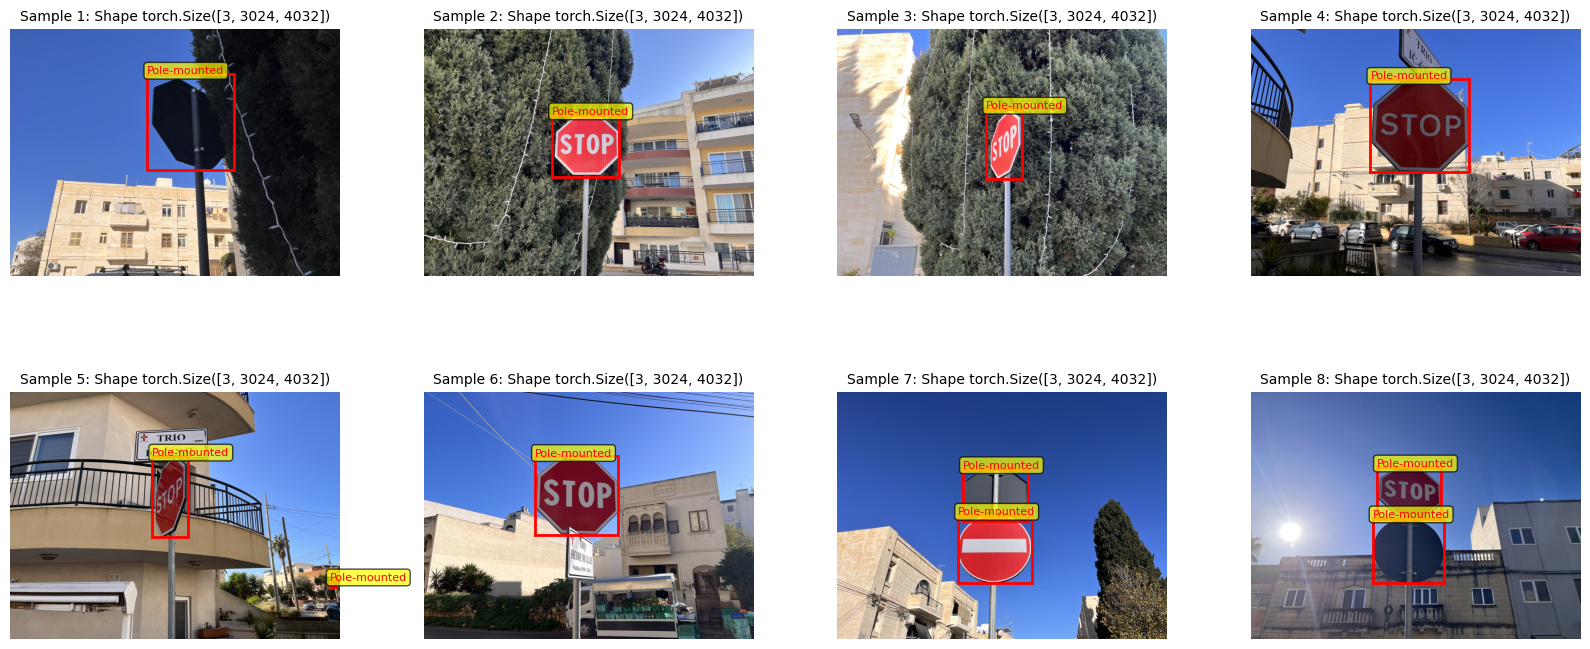

Creating model...
Total parameters: 32,064,455
Trainable parameters: 31,842,055

Starting training...

Epoch 1/50
Learning rate: 0.000030
  Batch   0/122: Loss = 2.9577
  Batch  10/122: Loss = 2.2299
  Batch  20/122: Loss = 1.5375
  Batch  30/122: Loss = 1.4713
  Batch  40/122: Loss = 1.3916
  Batch  50/122: Loss = 1.3701
  Batch  60/122: Loss = 1.2692
  Batch  70/122: Loss = 1.5499
  Batch  80/122: Loss = 1.1795
  Batch  90/122: Loss = 1.1536
  Batch 100/122: Loss = 1.1263
  Batch 110/122: Loss = 1.1260
  Batch 120/122: Loss = 1.3763

  Epoch Summary:
    Total Loss: 1.5017
    Cls Loss:   0.4102
    Box Loss:   0.4630

Epoch 1 Summary:
  Average train loss: 1.5017
  Average val loss:   1.3092
    Val cls loss:     0.3474
    Val box loss:     0.3500


c:\Users\user\anaconda3\envs\ARI3129\lib\site-packages\torch\optim\lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  ✓ Saved best model (loss: 1.3092)

Epoch 2/50
Learning rate: 0.000300
  Batch   0/122: Loss = 1.2160
  Batch  10/122: Loss = 1.5421
  Batch  20/122: Loss = 2.0545
  Batch  30/122: Loss = 1.6870
  Batch  40/122: Loss = 1.6064
  Batch  50/122: Loss = 1.6828
  Batch  60/122: Loss = 1.7497
  Batch  70/122: Loss = 1.5261
  Batch  80/122: Loss = 1.3952
  Batch  90/122: Loss = 1.3826
  Batch 100/122: Loss = 1.5645
  Batch 110/122: Loss = 1.4971
  Batch 120/122: Loss = 1.3788

  Epoch Summary:
    Total Loss: 1.6600
    Cls Loss:   0.5578
    Box Loss:   0.4566

Epoch 2 Summary:
  Average train loss: 1.6600
  Average val loss:   1.3861
    Val cls loss:     0.3530
    Val box loss:     0.4137
  Loss change: +0.1583
Loss increased

Epoch 3/50
Learning rate: 0.000300
  Batch   0/122: Loss = 1.3135


RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
from torch.optim.lr_scheduler import LinearLR, SequentialLR, CosineAnnealingLR
def main():
    
    data_root = 'COCO-based_COCO_mounting'
    train_img_dir = f'{data_root}/images/train'
    val_img_dir = f'{data_root}/images/val'
    train_anno = f'{data_root}/annotations/train.json'
    val_anno = f'{data_root}/annotations/val.json'
    
    num_classes = 2
    batch_size = 4
    num_epochs = 50    
    lr = 3e-4
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using device: {device}')
    
    # initialise datasets and dataloaders
    print('Loading datasets...')
    train_dataset = SignMountDataset(train_img_dir, train_anno, get_transform())
    val_dataset = SignMountDataset(val_img_dir, val_anno, get_transform())
    
    print(f'Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}')

    from torch.utils.data import WeightedRandomSampler

    def make_image_weights(dataset):
        # weight each image by whether it contains wall-mounted (label==1)
        weights = []
        for idx in range(len(dataset)):
            _, tgt = dataset[idx]
            labels = tgt["labels"].numpy().tolist()
            has_wall = 1 in labels
            # tune these numbers
            weights.append(6.0 if has_wall else 1.0)
        return np.array(weights, dtype=np.float64)

    weights = make_image_weights(train_dataset)
    sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        #shuffle=True, 
        sampler=sampler,
        collate_fn=collate_fn, 
        num_workers=0,  # Use 0 for Windows
        pin_memory=True if torch.cuda.is_available() else False
    )
    val_loader = DataLoader(
        val_dataset, 
        batch_size=10, 
        shuffle=False, 
        collate_fn=collate_fn, 
        num_workers=0,
        pin_memory=True if torch.cuda.is_available() else False
    )
    visualize_dataset_samples(train_dataset)
    # Model
    print('Creating model...')
    model = create_model(num_classes)
    model.to(device)
    
    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'Total parameters: {total_params:,}')
    print(f'Trainable parameters: {trainable_params:,}')
    
    params = [p for p in model.parameters() if p.requires_grad] 
    optimizer = torch.optim.AdamW(params, lr=lr, weight_decay=0.0001) 
    lr_scheduler = torch.optim.lr_scheduler.MultiStepLR( optimizer, milestones=[30, 40], gamma=0.1 )
    
    # tensorboard writer
    writer = SummaryWriter('runs/sign_mount_detection_experiment3')
    
    # training loop
    print('\nStarting training...')
    best_loss = float('inf')
    losses_history = []
    
    
    for epoch in range(num_epochs):
        print(f'\n{"="*60}')
        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'{"="*60}')
        print(f'Learning rate: {optimizer.param_groups[0]["lr"]:.6f}')
        
        train_loss = train_one_epoch(model, optimizer, train_loader, device, epoch, writer)
        losses_history.append(train_loss)
        val_loss, val_cls, val_box = compute_val_loss(model, val_loader, device, epoch, writer, max_batches=5)
        print(f'\nEpoch {epoch+1} Summary:')
        print(f'  Average train loss: {train_loss:.4f}')
        print(f'  Average val loss:   {val_loss:.4f}')
        print(f'    Val cls loss:     {val_cls:.4f}')
        print(f'    Val box loss:     {val_box:.4f}')
        
        # check if loss is decreasing
        if epoch > 0:
            loss_change = train_loss - losses_history[-2]
            print(f'  Loss change: {loss_change:+.4f}')
            if loss_change > 0:
                print(f'Loss increased')
        
        lr_scheduler.step()
        writer.add_scalar('lr', optimizer.param_groups[0]['lr'], epoch)
        log_epoch_predictions(
        model,
        val_loader,
        device,
        writer,
        epoch=epoch,
        split="val",
        max_images=6,
        score_thresh=0.3,
        label_map={0: "Pole", 1: "Wall"}  
    )
        writer.flush()
            
        # save best model
        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), 'sign_mount_model_best.pth')
            print(f'  ✓ Saved best model (loss: {best_loss:.4f})')
        
        # save checkpoint every 10 epochs
        if (epoch + 1) % 10 == 0:
            checkpoint_path = f'checkpoint_epoch_{epoch+1}.pth'
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': train_loss,
                'losses_history': losses_history,
            }, checkpoint_path)
            print(f'  ✓ Saved checkpoint: {checkpoint_path}')
    
    # Save final model and losses
    torch.save(model.state_dict(), 'sign_mount_model_final.pth')
    print('\n✓ Training complete! Best model saved to: sign_mount_model_best.pth')
    
if __name__ == '__main__':
    main()


Using device: cuda
Loading TEST dataset...
Test samples: 122
Loading best model...


C:\Users\user\AppData\Local\Temp\ipykernel_19096\3733478344.py:448: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=d

Evaluating model on TEST set...
Calculating mAP@0.5...
Calculating mAP@0.75...

TEST SET EVALUATION RESULTS
mAP@0.5:  0.5982
mAP@0.75: 0.4891
Total predicted boxes: 163

Average Confidence:
  Pole-mounted: 0.7443
  Wall-mounted: 0.6755

Per-class Precision & Recall @ IoU=0.5
  Pole-mounted:
    Precision: 0.7133
    Recall:    0.7846
  Wall-mounted:
    Precision: 0.6500
    Recall:    0.6842

Per-class Precision & Recall @ IoU=0.75
  Pole-mounted:
    Precision: 0.6154
    Recall:    0.6769
  Wall-mounted:
    Precision: 0.5000
    Recall:    0.5263

Generating visualizations...

Evaluation complete!


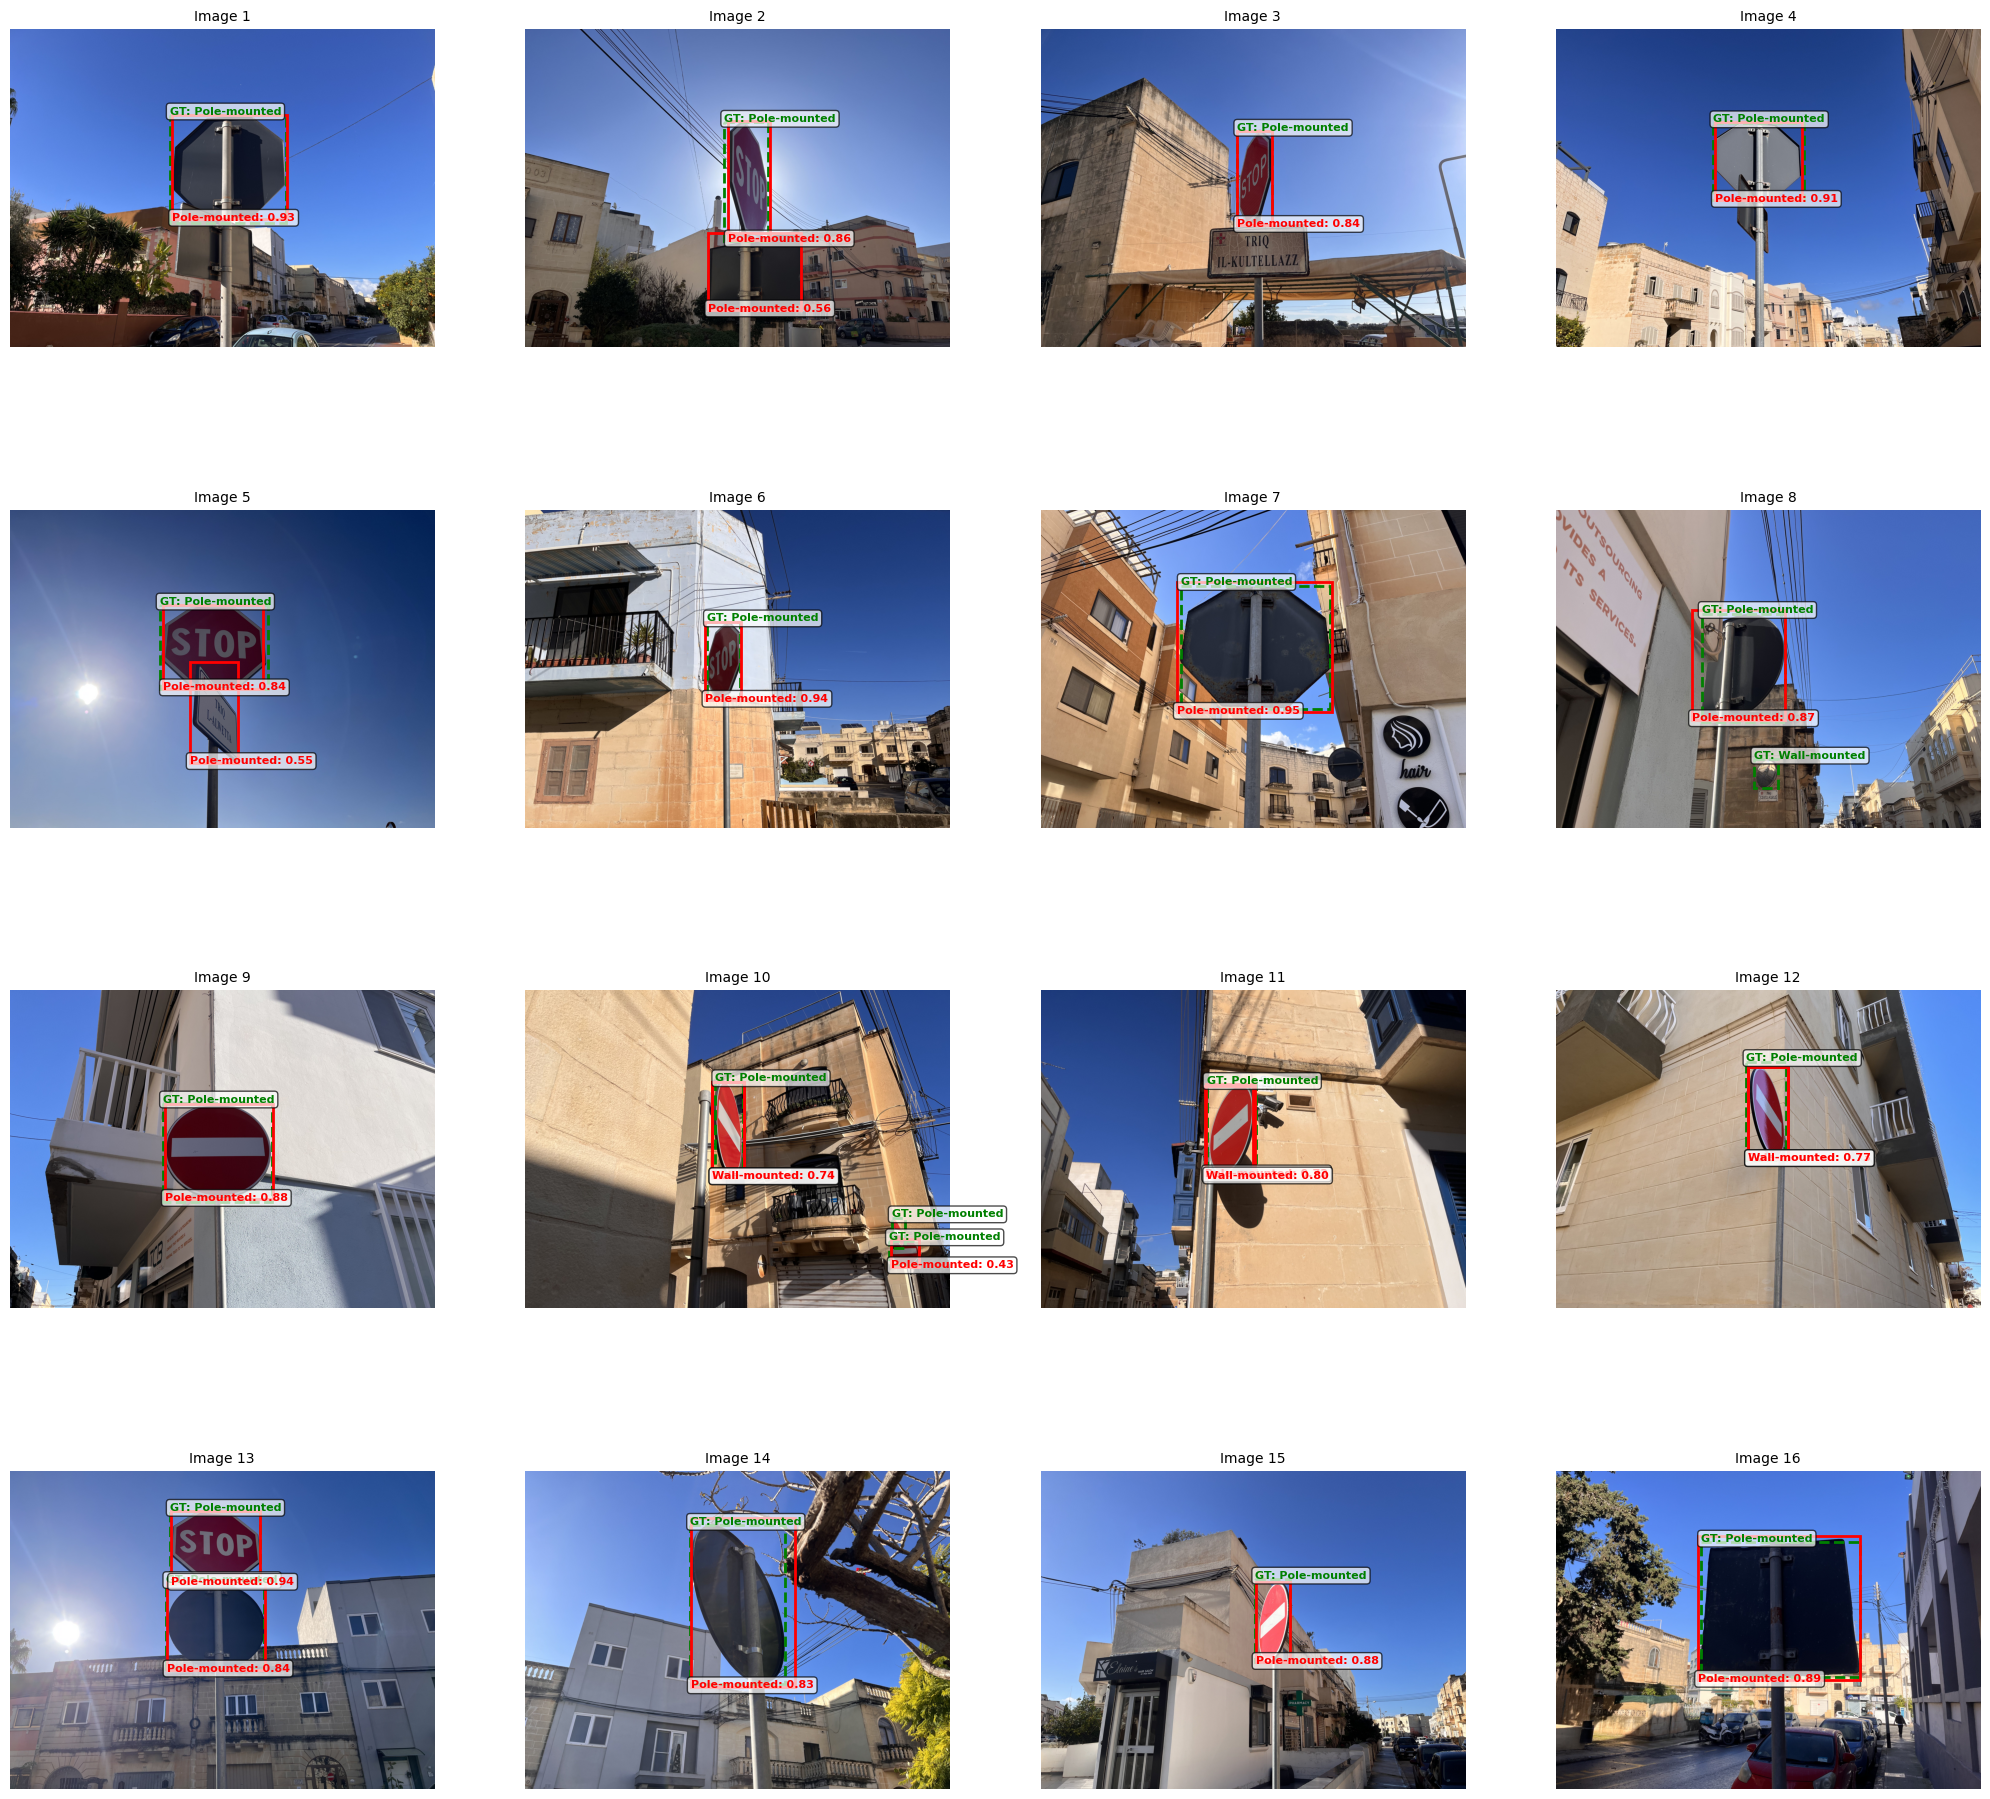

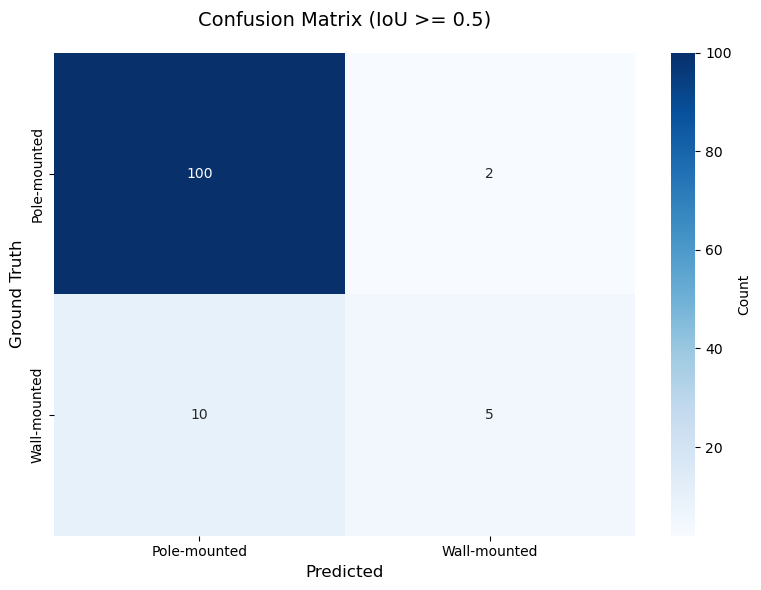

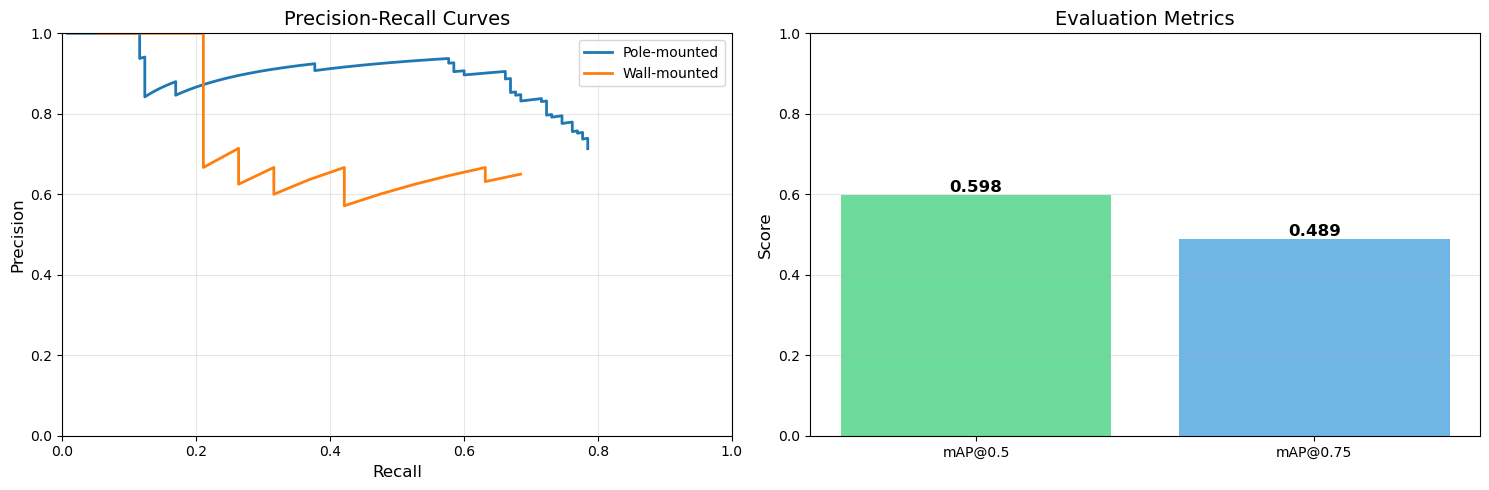

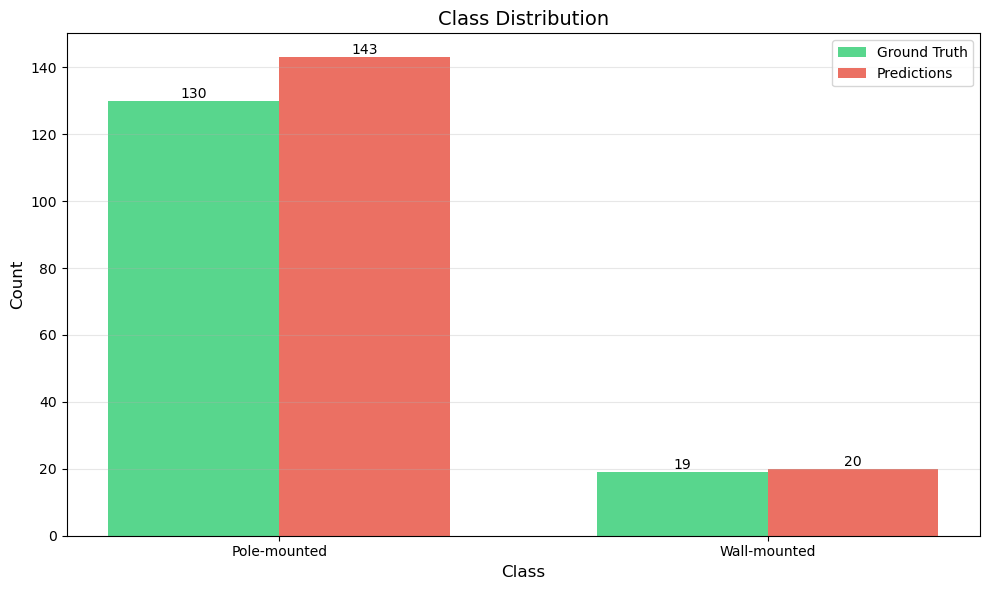

In [ ]:
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision.ops import box_iou, nms
import numpy as np
from collections import defaultdict
import seaborn as sns
from torch.utils.data import DataLoader


def calculate_map(predictions, targets, iou_threshold=0.5):
    all_precisions = []
    all_recalls = []

    active_classes = [0, 1]

    for class_id in active_classes:
        all_pred_boxes = []
        all_pred_scores = []
        all_gt_boxes = []

        for pred, target in zip(predictions, targets):
            class_mask = pred['labels'] == class_id
            pred_boxes = pred['boxes'][class_mask]
            pred_scores = pred['scores'][class_mask]

            gt_mask = target['labels'] == class_id
            gt_boxes = target['boxes'][gt_mask]

            all_pred_boxes.append(pred_boxes)
            all_pred_scores.append(pred_scores)
            all_gt_boxes.append(gt_boxes)

        precision, recall = calculate_precision_recall(
            all_pred_boxes, all_pred_scores, all_gt_boxes, iou_threshold
        )

        all_precisions.append(precision)
        all_recalls.append(recall)

    aps = []
    for precision, recall in zip(all_precisions, all_recalls):
        if len(precision) > 0:
            aps.append(compute_ap(recall, precision))

    return float(np.mean(aps)) if aps else 0.0, all_precisions, all_recalls

def summarize_precision_recall(precision_curves, recall_curves, class_names):
    for cls_idx, cls_name in enumerate(class_names):
        prec = precision_curves[cls_idx]
        rec  = recall_curves[cls_idx]

        if len(prec) == 0:
            print(f'  {cls_name}: no detections')
            continue

        final_precision = prec[-1]
        final_recall = rec[-1]

        print(f'  {cls_name}:')
        print(f'    Precision: {final_precision:.4f}')
        print(f'    Recall:    {final_recall:.4f}')




def calculate_precision_recall(pred_boxes_list, pred_scores_list, gt_boxes_list, iou_threshold):
    # flatten all predictions and sort by score
    all_preds = []
    for img_idx, (boxes, scores) in enumerate(zip(pred_boxes_list, pred_scores_list)):
        for box, score in zip(boxes, scores):
            all_preds.append({
                'box': box.cpu(),
                'score': score.item(),
                'image_idx': img_idx
            })
    
    # sort by confidence score descending
    all_preds.sort(key=lambda x: x['score'], reverse=True)
    
    # count total ground truths
    num_gt = sum(len(gt) for gt in gt_boxes_list)
    
    if num_gt == 0:
        return np.array([]), np.array([])
    
    # track which ground truths have been matched
    gt_matched = [torch.zeros(len(gt), dtype=torch.bool) for gt in gt_boxes_list]
    
    tp = []
    fp = []
    
    for pred in all_preds:
        img_idx = pred['image_idx']
        pred_box = pred['box']
        gt_boxes = gt_boxes_list[img_idx].cpu()
        
        if len(gt_boxes) == 0:
            fp.append(1)
            tp.append(0)
            continue
        
        ious = box_iou(pred_box.unsqueeze(0), gt_boxes)[0]
        max_iou, max_idx = ious.max(0)
        
        if max_iou >= iou_threshold and not gt_matched[img_idx][max_idx]:
            tp.append(1)
            fp.append(0)
            gt_matched[img_idx][max_idx] = True
        else:
            tp.append(0)
            fp.append(1)
    
    tp = np.cumsum(tp)
    fp = np.cumsum(fp)
    
    recall = tp / num_gt
    precision = tp / (tp + fp + 1e-10)
    
    return precision, recall


def compute_ap(recall, precision):

    recall = np.concatenate(([0.0], recall, [1.0]))
    precision = np.concatenate(([0.0], precision, [0.0]))
    
    for i in range(len(precision) - 2, -1, -1):
        precision[i] = max(precision[i], precision[i + 1])
    
    ap = 0.0
    for t in np.linspace(0, 1, 11):
        if np.sum(recall >= t) == 0:
            p = 0
        else:
            p = np.max(precision[recall >= t])
        ap += p / 11.0
    
    return ap

@torch.no_grad()
def evaluate_model(model, data_loader, device,
                   conf_threshold=0.2,
                   nms_threshold=0.4,
                   topk_per_image=5):

    model.eval()

    all_predictions = []
    all_targets = []
    all_images = []

    for images, targets in data_loader:
        images_device = [img.to(device) for img in images]
        predictions = model(images_device)

        for pred in predictions:
            # move to cpu to avoid cuda error 
            boxes = pred["boxes"].detach().cpu()
            labels = pred["labels"].detach().cpu()
            scores = pred["scores"].detach().cpu()

            # filter by confidence
            keep = scores >= conf_threshold
            boxes, labels, scores = boxes[keep], labels[keep], scores[keep]

            if scores.numel() == 0:
                pred["boxes"] = torch.empty((0, 4))
                pred["labels"] = torch.empty((0,), dtype=torch.long)
                pred["scores"] = torch.empty((0,))
                continue

            # class wise nms
            kept_boxes, kept_labels, kept_scores = [], [], []
            for class_id in torch.unique(labels):
                m = labels == class_id
                b = boxes[m]
                s = scores[m]
                keep_idx = nms(b, s, nms_threshold)

                kept_boxes.append(b[keep_idx])
                kept_labels.append(labels[m][keep_idx])
                kept_scores.append(s[keep_idx])

            boxes = torch.cat(kept_boxes, dim=0)
            labels = torch.cat(kept_labels, dim=0)
            scores = torch.cat(kept_scores, dim=0)

            # keep top k boxes per image
            if topk_per_image is not None and scores.numel() > topk_per_image:
                top_idx = torch.topk(scores, k=topk_per_image).indices
                boxes, labels, scores = boxes[top_idx], labels[top_idx], scores[top_idx]

            pred["boxes"] = boxes
            pred["labels"] = labels
            pred["scores"] = scores

        all_predictions.extend(predictions)
        all_targets.extend(targets)
        all_images.extend(images)

    return all_images, all_predictions, all_targets


def plot_predictions_grid(images, predictions, targets, num_images=30, conf_threshold=0.5):
    num_images = min(num_images, len(images))
    cols = 4
    rows = (num_images + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(20, 5*rows))
    if rows == 1 and cols == 1: axes = np.array([[axes]])
    elif rows == 1: axes = axes.reshape(1, -1)
    elif cols == 1: axes = axes.reshape(-1, 1)

    class_map = {0: 'Pole-mounted', 1: 'Wall-mounted'}
    colors = {'gt': 'green', 'pred': 'red'}

    for idx in range(num_images):
        row = idx // cols
        col = idx % cols
        ax = axes[row, col]

        img = images[idx].clone()
        ax.imshow(img.permute(1, 2, 0).cpu().numpy())
        ax.axis('off')

        # truth
        for box, label in zip(targets[idx]['boxes'], targets[idx]['labels']):
            x1, y1, x2, y2 = box.tolist()
            label_name = class_map.get(label.item(), f'Unk {label.item()}')
            rect = patches.Rectangle((x1, y1), x2-x1, y2-y1,
                                     linewidth=2, edgecolor=colors['gt'],
                                     facecolor='none', linestyle='--')
            ax.add_patch(rect)
            ax.text(x1, max(0, y1-5), f'GT: {label_name}', color=colors['gt'],
                    fontsize=8, weight='bold',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))

        # predictions
        pred = predictions[idx]
        for box, score, label in zip(pred['boxes'], pred['scores'], pred['labels']):
            if score >= conf_threshold:
                x1, y1, x2, y2 = box.tolist()
                label_name = class_map.get(label.item(), f'Unk {label.item()}')
                rect = patches.Rectangle((x1, y1), x2-x1, y2-y1,
                                         linewidth=2, edgecolor=colors['pred'],
                                         facecolor='none')
                ax.add_patch(rect)
                ax.text(x1, y2+15, f'{label_name}: {score:.2f}', color=colors['pred'],
                        fontsize=8, weight='bold',
                        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))

        ax.set_title(f'Image {idx+1}', fontsize=10)

    for idx in range(num_images, rows * cols):
        axes[idx // cols, idx % cols].axis('off')

    plt.tight_layout()
    return fig

def plot_confusion_matrix(predictions, targets, iou_threshold=0.5):
    class_names = ['Pole-mounted', 'Wall-mounted']
    confusion = np.zeros((2, 2), dtype=int)

    for pred, target in zip(predictions, targets):
        gt_boxes = target['boxes'].cpu()
        gt_labels = target['labels'].cpu()
        pred_boxes = pred['boxes'].cpu()
        pred_labels = pred['labels'].cpu()

        if len(gt_boxes) == 0 or len(pred_boxes) == 0:
            continue

        for gt_box, gt_label in zip(gt_boxes, gt_labels):
            gt_idx = gt_label.item()
            if gt_idx not in (0, 1):
                continue

            ious = box_iou(gt_box.unsqueeze(0), pred_boxes)[0]
            max_iou, max_idx = ious.max(0)

            if max_iou >= iou_threshold:
                pred_idx = pred_labels[max_idx].item()
                if pred_idx in (0, 1):
                    confusion[gt_idx, pred_idx] += 1

    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                ax=ax, cbar_kws={'label': 'Count'})
    ax.set_xlabel('Predicted', fontsize=12)
    ax.set_ylabel('Ground Truth', fontsize=12)
    ax.set_title('Confusion Matrix (IoU >= 0.5)', fontsize=14, pad=20)
    plt.tight_layout()
    return fig


def plot_metrics_summary(map50, map75, precision_curves, recall_curves):
    class_names = ['Pole-mounted', 'Wall-mounted']
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Precision-Recall
    ax = axes[0]
    for i, (precision, recall) in enumerate(zip(precision_curves, recall_curves)):
        if len(precision) > 0:
            ax.plot(recall, precision, label=class_names[i], linewidth=2)
    ax.set_xlabel('Recall', fontsize=12)
    ax.set_ylabel('Precision', fontsize=12)
    ax.set_title('Precision-Recall Curves', fontsize=14)
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    
    # Metrics Bar
    ax = axes[1]
    metrics = ['mAP@0.5', 'mAP@0.75']
    values = [map50, map75]
    bars = ax.bar(metrics, values, color=['#2ecc71', '#3498db'], alpha=0.7)
    ax.set_ylabel('Score', fontsize=12)
    ax.set_title('Evaluation Metrics', fontsize=14)
    ax.set_ylim([0, 1])
    ax.grid(True, alpha=0.3, axis='y')
    
    for bar, value in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{value:.3f}', ha='center', va='bottom', fontsize=12, weight='bold')
    
    plt.tight_layout()
    return fig

def analyze_performance(predictions, targets):
    class_map = {0: 'Pole-mounted', 1: 'Wall-mounted'}
    stats = {
        'total_images': len(predictions),
        'total_gt_boxes': sum(len(t['boxes']) for t in targets),
        'total_pred_boxes': sum(len(p['boxes']) for p in predictions),
        'class_distribution_gt': defaultdict(int),
        'class_distribution_pred': defaultdict(int),
        'avg_confidence': defaultdict(list),
    }

    for pred, target in zip(predictions, targets):
        for label in target['labels']:
            stats['class_distribution_gt'][class_map.get(label.item(), 'Unknown')] += 1

        for label, score in zip(pred['labels'], pred['scores']):
            name = class_map.get(label.item(), 'Unknown')
            stats['class_distribution_pred'][name] += 1
            stats['avg_confidence'][name].append(score.item())

    for class_name in class_map.values():
        scores = stats['avg_confidence'].get(class_name, [])
        stats['avg_confidence'][class_name] = float(np.mean(scores)) if len(scores) else 0.0

    return stats

def plot_class_distribution(stats):
    class_names = list(stats['class_distribution_gt'].keys())
    class_names.sort() 
    
    gt_counts = [stats['class_distribution_gt'][c] for c in class_names]
    pred_counts = [stats['class_distribution_pred'].get(c, 0) for c in class_names]
    
    fig, ax = plt.subplots(figsize=(10, 6))
    x = np.arange(len(class_names))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, gt_counts, width, label='Ground Truth', alpha=0.8, color='#2ecc71')
    bars2 = ax.bar(x + width/2, pred_counts, width, label='Predictions', alpha=0.8, color='#e74c3c')
    
    ax.set_xlabel('Class', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.set_title('Class Distribution', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(class_names)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height)}', ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    return fig


def evaluate_and_visualize():
    data_root = 'COCO-based_COCO_mounting'
    test_img_dir = f'{data_root}/images/test'
    test_anno = f'{data_root}/annotations/test.json'
    model_path = 'sign_mount_model_final.pth'

    num_classes = 2 

    batch_size = 4
    conf_threshold = 0.2

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using device: {device}')

    print('Loading TEST dataset...')
    test_dataset = SignMountDataset(test_img_dir, test_anno, get_transform())
    test_loader = DataLoader(test_dataset, batch_size=batch_size,
                             shuffle=False, collate_fn=collate_fn, num_workers=0)

    print(f'Test samples: {len(test_dataset)}')

    print('Loading best model...')
    model = create_model(num_classes)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)

    print('Evaluating model on TEST set...')
    images, predictions, targets = evaluate_model(
        model, test_loader, device,
        conf_threshold=0.3,
        nms_threshold=0.4,
        topk_per_image=3   # try 3, 5, or 10
    )
    print('Calculating mAP@0.5...')
    map50, precision_curves_50, recall_curves_50 = calculate_map(predictions, targets, iou_threshold=0.5)

    print('Calculating mAP@0.75...')
    map75, precision_curves_75, recall_curves_75 = calculate_map(predictions, targets, iou_threshold=0.75)

    stats = analyze_performance(predictions, targets)

    print('\n' + '='*60)
    print('TEST SET EVALUATION RESULTS')
    print('='*60)
    print(f'mAP@0.5:  {map50:.4f}')
    print(f'mAP@0.75: {map75:.4f}')
    print(f'Total predicted boxes: {stats["total_pred_boxes"]}')
    print('\nAverage Confidence:')
    for k, v in stats['avg_confidence'].items():
        print(f'  {k}: {v:.4f}')
    print('='*60)

    class_names = ['Pole-mounted', 'Wall-mounted']

    print('\nPer-class Precision & Recall @ IoU=0.5')
    summarize_precision_recall(
        precision_curves_50,
        recall_curves_50,
        class_names
    )

    print('\nPer-class Precision & Recall @ IoU=0.75')
    summarize_precision_recall(
        precision_curves_75,
        recall_curves_75,
        class_names
)

    print('\nGenerating visualizations...')
    plot_predictions_grid(images, predictions, targets, num_images=16, conf_threshold=conf_threshold)
    #plt.savefig('test_predictions_grid.png', dpi=150, bbox_inches='tight')

    plot_confusion_matrix(predictions, targets)
    #plt.savefig('test_confusion_matrix.png', dpi=150, bbox_inches='tight')

    plot_metrics_summary(map50, map75, precision_curves_50, recall_curves_50)
    #plt.savefig('test_metrics_summary.png', dpi=150, bbox_inches='tight')

    plot_class_distribution(stats)
    #plt.savefig('test_class_distribution.png', dpi=150, bbox_inches='tight')

    print('\nEvaluation complete!')
    return map50, map75, stats

if __name__ == '__main__':
    evaluate_and_visualize()